##Importing all important library

In [53]:
import warnings
warnings.filterwarnings("ignore")
import re
import string
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
import matplotlib.pyplot as plt
import random
import nltk
import spacy
import polars as pl
from gensim.models import Word2Vec
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import FunctionTransformer
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,classification_report
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OrdinalEncoder, StandardScaler

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')
sample_submission_df  = pd.read_csv('/content/sample_submission.csv')

In [5]:
print(f'shape of train data {train_df.shape},  test data {test_df.shape} ,sub data {sample_submission_df.shape}')

shape of train data (7613, 5),  test data (3263, 4) ,sub data (3263, 2)


In [6]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [21]:
print("Most top keywords:\n", train_df.keyword.value_counts().iloc[:5])

Most top keywords:
 keyword
fatalities    45
armageddon    42
deluge        42
harm          41
damage        41
Name: count, dtype: int64


In [23]:
print("How many number countries of the senders tweets: ", train_df.location.nunique())

How many number countries of the senders tweets:  3341


In [7]:
train_df.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [8]:
train_df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [12]:
import polars as pl

# Convert Pandas DataFrame to Polars DataFrame
train_df_pl = pl.from_pandas(train_df)

positive_tweets = train_df_pl.filter(pl.col('target') == 1)
negative_tweets = train_df_pl.filter(pl.col('target') == 0)

print(f'shape of positive tweets {positive_tweets.shape} and  negative tweet shape {negative_tweets.shape}')

shape of positive tweets (3271, 5) and  negative tweet shape (4342, 5)


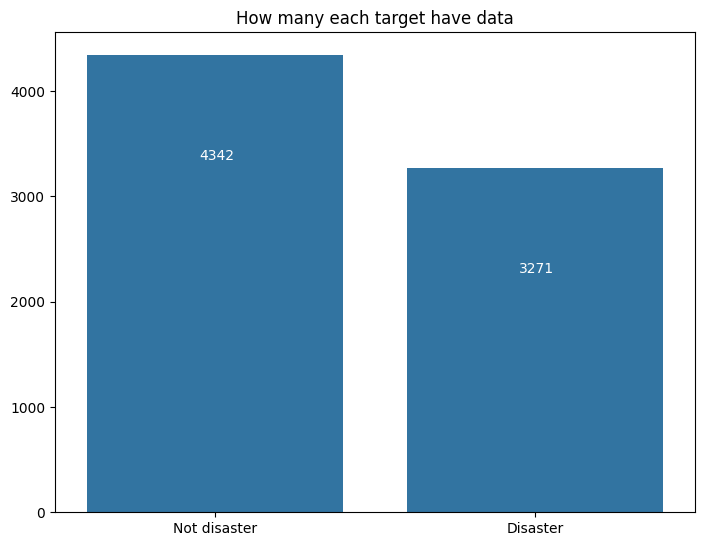

In [26]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])

sns.countplot(x='target', data=train_df, ax=ax)

for index_col, count in enumerate(train_df.target.value_counts()):
    plt.text(index_col-0.05, count-1000, count, color='white')

ax.set_xticklabels(["Not disaster", "Disaster"])
ax.set_title('How many each target have data')
ax.set_ylabel('')
ax.set_xlabel('')

plt.show()

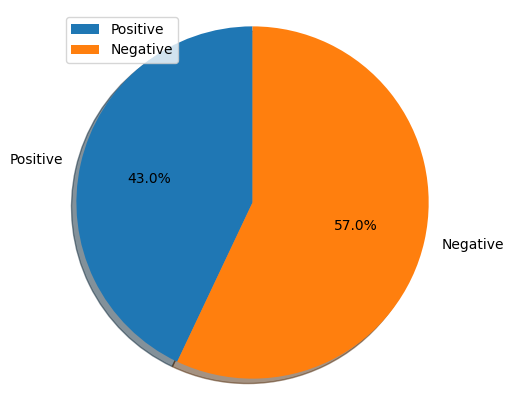

In [14]:
fig = plt.figure(figsize=(5,5))
labels = 'Positive', 'Negative'
# size for each slide
sizes = [len(positive_tweets), len(negative_tweets)]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.legend()
plt.axis('equal')

plt.show()

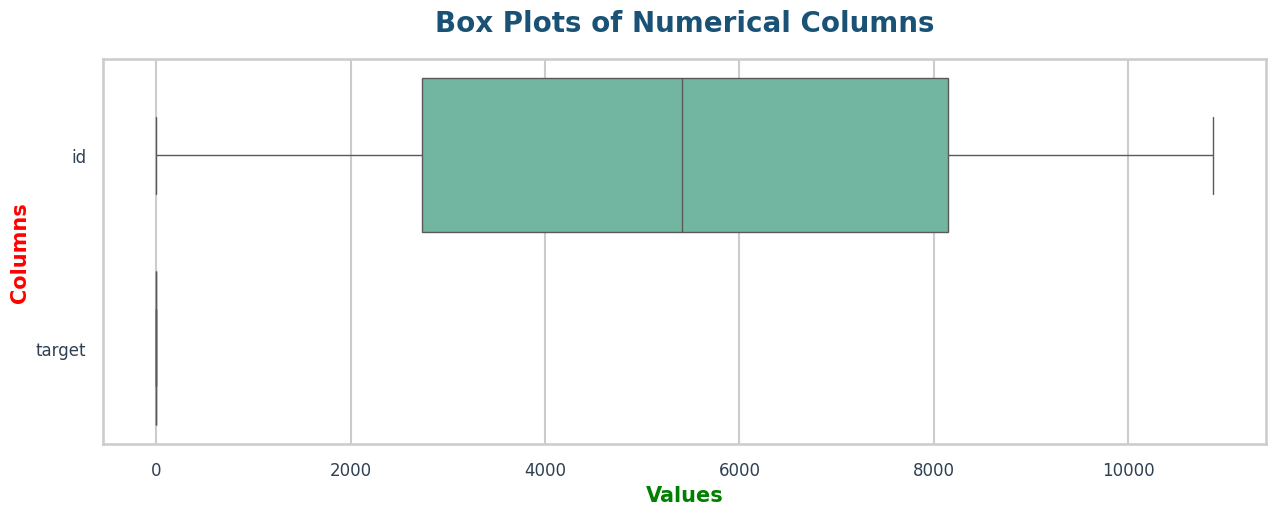

In [28]:
sns.set_style('whitegrid')
sns.set_context('talk')

plt.figure(figsize=(15, 5))
ax = sns.boxplot(data=train_df, orient='h', palette='Set2')

plt.title('Box Plots of Numerical Columns', fontsize=20, fontweight='bold', color='#1A5276', pad=20)
plt.xlabel('Values', fontsize=15, fontweight='bold', color='green')
plt.ylabel('Columns', fontsize=15, fontweight='bold', color='red')

ax.tick_params(axis='x', colors='#2E4053', labelsize=12)
ax.tick_params(axis='y', colors='#2E4053', labelsize=12)

for patch in ax.artists:
    patch.set_edgecolor('#1A5276')
    patch.set_linewidth(2)

plt.show()

##Data Cleaning, Data Handling and Preprocessing and finally model training

In [18]:
print('\033[92m' + str(positive_tweets.sample(1)['text'].to_list()))
print('\033[91m' + str(negative_tweets.sample(1)['text'].to_list()))

['@GettingLost @JennEllensBB @Muncle_jim It said they had superficial wounds and it was the pepper spray that did the most damage.']
["How to ruin the holidays in 3 wordk: 'It's a Zmne!'"]


In [20]:
example = positive_tweets[2277]['text'].to_list()
example = example[0]
example

'Police kill hatchet-wielding gunman who opened fire inside Nashville movie theater: AåÊmiddle-aged manåÊarmed wi... http://t.co/tyD47NfL5x'

In [29]:
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [31]:
#imputing values
train_df['keyword'] = train_df['keyword'].fillna(train_df['keyword'].mode()[0])
train_df['location'] = train_df['location'].fillna(value='Missing')

In [33]:
train_df.isnull().sum()# so we handles missed values

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [36]:
train_df['text'] = train_df['text'].str.lower() # lower the case in sentence

In [37]:
pd.DataFrame(train_df['text'].head(5))

,text
0,our deeds are the reason of this #earthquake m...
1,forest fire near la ronge sask. canada
2,all residents asked to 'shelter in place' are ...
3,"13,000 people receive #wildfires evacuation or..."
4,just got sent this photo from ruby #alaska as ...


In [48]:
import nltk
nltk.download('punkt')

def remove_html_tags(text):
    clean_text = re.sub('<.*?>', '', text)# removing html tags
    return clean_text

train_df['text'] = train_df['text'].apply(remove_html_tags)

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')#removing url
    clean_text = re.sub(url_pattern, '', text)
    return clean_text
train_df['text'] = train_df['text'].apply(remove_urls)

def remove_punctuation(text):
    punctuation = string.punctuation
    clean_text = text.translate(str.maketrans('', '', punctuation))
    return clean_text
train_df['text'] = train_df['text'].apply(remove_punctuation)

def remove_stop_words(text):
	tokens = nltk.word_tokenize(text)
	stop_words = set(stopwords.words('english'))
	filtered_tokens = [token for token in tokens if token not in stop_words] # removing stop words
	preprocessed_text = ' '.join(filtered_tokens)
	return preprocessed_text
train_df['text'] = train_df['text'].apply(remove_stop_words)


pd.DataFrame(train_df['text'].head(5))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,text
0,deeds reason earthquake may allah forgive us
1,forest fire near la ronge sask canada
2,residents asked shelter place notified officer...
3,13000 people receive wildfires evacuation orde...
4,got sent photo ruby alaska smoke wildfires pou...


In [49]:
#Handleing emoji
def replace_emojis_with_meanings(text):
    def replace(match):
        emoji_char = match.group()
        emoji_meaning = emoji.demojize(emoji_char)
        return emoji_meaning

    emoji_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"
                            u"\U0001F300-\U0001F5FF"
                            u"\U0001F680-\U0001F6FF"
                            u"\U0001F1E0-\U0001F1FF"
                            u"\U00002500-\U00002BEF"
                            u"\U00002702-\U000027B0"
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            u"\U0001f926-\U0001f937"
                            u"\U00010000-\U0010ffff"
                            u"\u2640-\u2642"
                            u"\u2600-\u2B55"
                            u"\u200d"
                            u"\u23cf"
                            u"\u23e9"
                            u"\u231a"
                            u"\ufe0f"
                            u"\u3030"
                            "]+", flags=re.UNICODE)
    text_with_meanings = emoji_pattern.sub(replace, text)
    return text_with_meanings

train_df['text'] = train_df['text'].apply(replace_emojis_with_meanings)
pd.DataFrame(train_df['text'].head(5))


,text
0,deeds reason earthquake may allah forgive us
1,forest fire near la ronge sask canada
2,residents asked shelter place notified officer...
3,13000 people receive wildfires evacuation orde...
4,got sent photo ruby alaska smoke wildfires pou...


##Tokenization ans Pos

In [50]:
def word_tokenization(text):
    return nltk.word_tokenize(text)
train_df['token_text'] = train_df['text'].apply(word_tokenization)
pd.DataFrame(train_df['text'].head(5))

,text
0,deeds reason earthquake may allah forgive us
1,forest fire near la ronge sask canada
2,residents asked shelter place notified officer...
3,13000 people receive wildfires evacuation orde...
4,got sent photo ruby alaska smoke wildfires pou...


In [58]:
#pos tagging
from tqdm import tqdm
nlp = spacy.load('en_core_web_sm', disable=['ner', 'textcat'])

def batch_pos_tagging(texts):
    docs = list(nlp.pipe(texts, batch_size=50))
    return [[(token.text, token.pos_) for token in doc] for doc in docs]

batch_size = 50
num_batches = (len(train_df) + batch_size - 1) // batch_size

pos_tags = []
for i in tqdm(range(num_batches)):
    start = i * batch_size
    end = min((i + 1) * batch_size, len(train_df))
    batch_texts = train_df['text'][start:end].tolist()
    pos_tags.extend(batch_pos_tagging(batch_texts))

train_df['POS_Tags'] = pos_tags

100%|██████████| 153/153 [00:09<00:00, 15.61it/s]


In [59]:
train_df.head()

,id,keyword,location,text,target,token_text,POS_Tags
0,1,fatalities,Missing,deeds reason earthquake may allah forgive us,1,"[deeds, reason, earthquake, may, allah, forgiv...","[(deeds, VERB), (reason, NOUN), (earthquake, N..."
1,4,fatalities,Missing,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]","[(forest, NOUN), (fire, NOUN), (near, ADP), (l..."
2,5,fatalities,Missing,residents asked shelter place notified officer...,1,"[residents, asked, shelter, place, notified, o...","[(residents, NOUN), (asked, VERB), (shelter, N..."
3,6,fatalities,Missing,13000 people receive wildfires evacuation orde...,1,"[13000, people, receive, wildfires, evacuation...","[(13000, NUM), (people, NOUN), (receive, VERB)..."
4,7,fatalities,Missing,got sent photo ruby alaska smoke wildfires pou...,1,"[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, AUX), (sent, VERB), (photo, NOUN), (rub..."


In [63]:
train_df['token_text'] = train_df['token_text'].apply(lambda x: ' '.join(x))
train_df['POS_Tags'] = train_df['POS_Tags'].apply(lambda x: ' '.join([i[1] if len(i) > 1 else '' for i in x]))
train_df.head()

,id,keyword,location,text,target,token_text,POS_Tags
0,1,fatalities,Missing,deeds reason earthquake may allah forgive us,1,d e e d s r e a s o n ...,
1,4,fatalities,Missing,forest fire near la ronge sask canada,1,f o r e s t f i r e ...,
2,5,fatalities,Missing,residents asked shelter place notified officer...,1,r e s i d e n t s a s ...,...
3,6,fatalities,Missing,13000 people receive wildfires evacuation orde...,1,1 3 0 0 0 p e o p l e ...,
4,7,fatalities,Missing,got sent photo ruby alaska smoke wildfires pou...,1,g o t s e n t p h o ...,


In [66]:
#model creation and training
class TextLengthExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return pd.DataFrame(X['text'].apply(len))

class NumHashtagsExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return pd.DataFrame(X['text'].apply(lambda x: len([word for word in x.split() if word.startswith('#')])))

class NumMentionsExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return pd.DataFrame(X['text'].apply(lambda x: len([word for word in x.split() if word.startswith('@')])))

# train_test_split
X = train_df[['text']]
y = train_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#pipelines creation ......
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('selector', FunctionTransformer(lambda x: x['text'], validate=False)),
            ('tfidf', TfidfVectorizer(max_features=10000))
        ])),
        ('text_length', Pipeline([
            ('selector', FunctionTransformer(lambda x: x, validate=False)),
            ('extract', TextLengthExtractor())
        ])),
        ('num_hashtags', Pipeline([
            ('selector', FunctionTransformer(lambda x: x, validate=False)),
            ('extract', NumHashtagsExtractor())
        ])),
        ('num_mentions', Pipeline([
            ('selector', FunctionTransformer(lambda x: x, validate=False)),
            ('extract', NumMentionsExtractor())
        ]))
    ])),
    ('clf', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1))
])


param_grid = {
    'features__text__tfidf__max_features': [5000, 10000],
    'clf__n_estimators': [100, 200],
    'clf__learning_rate': [0.1, 0.01]
}




In [67]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('text',
                                                                        Pipeline(steps=[('selector',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x7b57967903a0>)),
                                                                                        ('tfidf',
                                                                                         TfidfVectorizer(max_features=10000))])),
                                                                       ('text_length',
                                                                        Pipeline(steps=[('selector',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x7b577c49ad40>)),
                                                                                        ('extract',...
                                                                                         NumHashtagsExtractor())])),
                                                                       ('num_mentions',
                                                                        Pipeline(steps=[('selector',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x7b577ca76cb0>)),
                                                                                        ('extract',
                                                                                         NumMentionsExtractor())]))])),
                                       ('clf', GradientBoostingClassifier())]),
             n_jobs=1,
             param_grid={'clf__learning_rate': [0.1, 0.01],
                         'clf__n_estimators': [100, 200],
                         'features__text__tfidf__max_features': [5000, 10000]},
             scoring='f1')

In [68]:
#classifiction report
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.74      0.90      0.81       874
           1       0.81      0.56      0.66       649

    accuracy                           0.76      1523
   macro avg       0.77      0.73      0.74      1523
weighted avg       0.77      0.76      0.75      1523



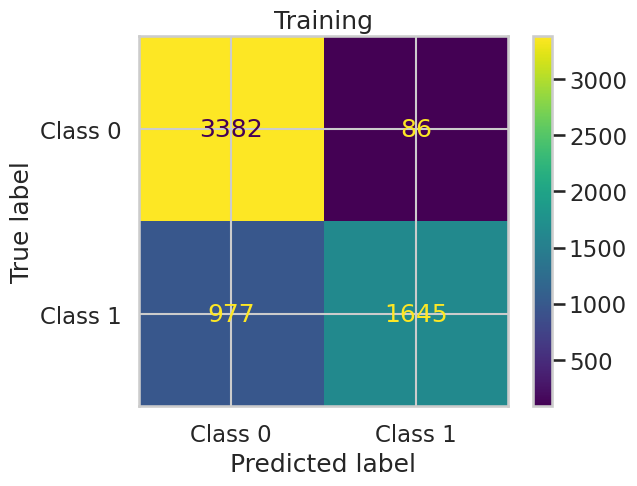

In [75]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
y_pred_train = grid_search.predict(X_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"]) # Replace with your class labels
# Set title using matplotlib
disp.plot()
plt.title("Training") # Set the title using matplotlib
plt.show()




In [76]:
test_df = pd.read_csv('/content/test.csv')
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [77]:
test_X = test_df[['text']]
y_pred_submission = best_model.predict(test_X)

In [79]:
submission_df.to_csv('submission.csv', index=False)
df_submission.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1


In [90]:
df_submission.to_csv('submission_final1.csv', index=False)

In [91]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 87.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 111.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 44.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.16.1 which is incompatible

In [95]:
import tensorflow as tf

BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = train_df.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE
from sklearn.model_selection import train_test_split

X =train_df["text"]
y = train_df["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = test_df["text"]

In [98]:
!pip install --upgrade keras
!pip install --upgrade keras-nlp